# KSE EP-OpInf Tests

This notebook contains the analysis of Test 1 (interpolation) and Test 2 (extrapolation)

In [1]:
using DataFrames
using FileIO
using JLD2
using LaTeXStrings
using LinearAlgebra
using Plots
using Plots.PlotMeasures
using ProgressMeter
using StatsBase

include("../src/model/KS.jl")
include("../src/LiftAndLearn.jl")
const LnL = LiftAndLearn

# Settings for the KS equation
KSE = KS(
    [0.0, 22.0], [0.0, 300.0], [1.0, 1.0],
    512, 0.001, 1, "ep"
)

# Create file name to save data
datafile = "data/kse_data_L22.jld2"
opfile = "data/kse_operators_L22.jld2"
resultfile = "data/kse_results_L22.jld2"
testresultfile = "data/kse_test_results_L22.jld2"
testicfile = "data/kse_test_ics_L22.jld2"

# Downsampling rate
DS = 100

# Down-sampled dimension of the time data
Tdim_ds = size(1:DS:KSE.Tdim, 1)  # downsampled time dimension

# Number of random test inputs
num_test_ic = 50

# Training initial conditions
ic_a = [0.8, 1.0, 1.2]
ic_b = [0.2, 0.4, 0.6]
;

In [2]:
# Parameterized function for the initial condition
L = KSE.Omega[2] - KSE.Omega[1]  # length of the domain
u0 = (a,b) -> a * cos.((2*π*KSE.x)/L) .+ b * cos.((4*π*KSE.x)/L)  # initial condition
;  

In [15]:
TEST_RES = load(testresultfile)
;

In [3]:
ICs = load(testicfile)
ic_a_rand_in = ICs["ic_a_rand_in"]
ic_b_rand_in = ICs["ic_b_rand_in"]
ic_a_rand_out = ICs["ic_a_rand_out"]
ic_b_rand_out = ICs["ic_b_rand_out"]
;

In [4]:
DATA = load(datafile)
OPS = load(opfile)
RES = load(resultfile)
;

## Autocorrelation Functions

In [4]:
function analyze_autocorr(op, model, Vr_all, IC, ro, integrator, lags)

    # auto_correletion
    auto_correlation = Array{Array{Float64}}(undef, length(ro), model.Pdim)

    for i in eachindex(model.μs)
        Threads.@threads for (j,r) in collect(enumerate(ro))
            Vr = Vr_all[i][:, 1:r]

            Fextract = LnL.extractF(op[i].F, r)
            X = integrator(op[i].A[1:r, 1:r], Fextract, model.t, Vr' * IC)
            Xrecon = Vr * X
            @inbounds auto_correlation[j, i] = tmean_autocorr(Xrecon, lags)
        end
    end
    return auto_correlation
end


function tmean_autocorr(X::AbstractArray, lags::AbstractVector)
    N, K = size(X)
    M = length(lags)
    Cx = zeros((N, M))
    
    for i in 1:N  # normalzied autocorrelation
        @inbounds Cx[i,:] = autocor(X[i,:], lags)
    end
    return vec(mean(Cx, dims=1))
end
;

## Test 1 

In [5]:
# Setup the results
TEST_RES = Dict{String, Any}()
TEST_RES["test1_AC"] = Dict(
    :int   => Array{Array{Float64}}(undef, length(DATA["ro"]), KSE.Pdim),
    :LS    => Array{Array{Float64}}(undef, length(DATA["ro"]), KSE.Pdim),
    :ephec => Array{Array{Float64}}(undef, length(DATA["ro"]), KSE.Pdim),
    :fom   => Array{Array{Float64}}(undef, KSE.Pdim)
)
TEST_RES["test1_AC_ERR"] = Dict(
    :int   => Array{Float64}(undef, length(DATA["ro"]), KSE.Pdim),
    :LS    => Array{Float64}(undef, length(DATA["ro"]), KSE.Pdim),
    :ephec => Array{Float64}(undef, length(DATA["ro"]), KSE.Pdim),
);

In [6]:
# Generate random initial condition parameters
ic_a_rand_in = (maximum(ic_a) - minimum(ic_a)) .* rand(num_test_ic) .+ minimum(ic_a)
ic_b_rand_in = (maximum(ic_b) - minimum(ic_b)) .* rand(num_test_ic) .+ minimum(ic_b)

i = 1
μ = KSE.μs[i]

# Generate the FOM system matrices (ONLY DEPENDS ON μ)
A = DATA["op_fom_tr"][i].A
F = DATA["op_fom_tr"][i].F

# lag for autocorrelation
lags = 0:DS:(KSE.Tdim ÷ 2)
idx = length(lags)

# Store some arrays
fom_ac1 = zeros(length(lags))
int_ac1 = zeros(length(lags), length(DATA["ro"]))
LS_ac1 = zeros(length(lags), length(DATA["ro"]))
ephec_ac1 = zeros(length(lags), length(DATA["ro"]))

int_ac_err1 = zeros(length(DATA["ro"]))
LS_ac_err1 = zeros(length(DATA["ro"]))
ephec_ac_err1 = zeros(length(DATA["ro"]))

# Generate the data for all combinations of the initial condition parameters
prog = Progress(num_test_ic)
Threads.@threads for j in 1:num_test_ic  
    # generate test 1 data
    a = ic_a_rand_in[j]
    b = ic_b_rand_in[j]
    IC = u0(a,b)
    Xtest_in = KSE.integrate_FD(A, F, KSE.t, IC)

    # compute autocorrelation of FOM
    fom_ac_j = tmean_autocorr(Xtest_in, lags)
    fom_ac1 .+= fom_ac_j

    # compute autocorrelation of ROMs
    int_ac_tmp = analyze_autocorr(OPS["op_int"], KSE, DATA["Vr"], IC, DATA["ro"], KSE.integrate_FD, lags)
    LS_ac_tmp = analyze_autocorr(OPS["op_LS"], KSE, DATA["Vr"], IC, DATA["ro"], KSE.integrate_FD, lags)
    ephec_ac_tmp = analyze_autocorr(OPS["op_ephec"], KSE, DATA["Vr"], IC, DATA["ro"], KSE.integrate_FD, lags)
    for r in eachindex(DATA["ro"])
        int_ac_err1[r] += norm(int_ac_tmp[r,1] - fom_ac_j, 2) / norm(fom_ac_j, 2)
        int_ac1[:,r] .+= int_ac_tmp[r,1]

        LS_ac_err1[r] += norm(LS_ac_tmp[r,1] - fom_ac_j, 2) / norm(fom_ac_j, 2)
        LS_ac1[:,r] .+= LS_ac_tmp[r,1]

        ephec_ac_err1[r] += norm(ephec_ac_tmp[r,1] - fom_ac_j, 2) / norm(fom_ac_j, 2)
        ephec_ac1[:,r] .+= ephec_ac_tmp[r,1]
    end
    next!(prog)
end

# Compute the average of all initial conditions as the final result
TEST_RES["test1_AC"][:fom][1] = fom_ac1 ./ num_test_ic
for r in eachindex(DATA["ro"])
    TEST_RES["test1_AC"][:int][r,1] = int_ac1[:,r] / num_test_ic
    TEST_RES["test1_AC"][:LS][r,1] = LS_ac1[:,r] / num_test_ic
    TEST_RES["test1_AC"][:ephec][r,1] = ephec_ac1[:,r] / num_test_ic

    TEST_RES["test1_AC_ERR"][:int][r,1] = int_ac_err1[r] / num_test_ic
    TEST_RES["test1_AC_ERR"][:LS][r,1] = LS_ac_err1[r] / num_test_ic
    TEST_RES["test1_AC_ERR"][:ephec][r,1] = ephec_ac_err1[r] / num_test_ic
end

Progress:  24%|██████████                               |  ETA: 6:31:00

Progress:  26%|███████████                              |  ETA: 10:22:21

Progress:  46%|███████████████████                      |  ETA: 4:46:30

Progress:  48%|████████████████████                     |  ETA: 4:24:35

Progress:  50%|█████████████████████                    |  ETA: 5:28:41

Progress:  74%|███████████████████████████████          |  ETA: 2:35:01

Progress:  98%|█████████████████████████████████████████|  ETA: 0:09:50

Progress: 100%|█████████████████████████████████████████| Time: 8:02:44


In [5]:
save(testresultfile, TEST_RES)

In [ ]:
lags_t = collect(lags) .* KSE.Δt
idx = length(lags_t)
lout = @layout [grid(2,2)]
p = plot(layout=lout, size=(1000, 500), plot_title="Test 1: interpolation")
for (plot_id, ri) in enumerate([1, 2, 5, 7])
    plot!(p[plot_id], lags_t[1:idx], TEST_RES["test1_AC"][:LS][ri][1:idx], c=:black, label="opinf")
    plot!(p[plot_id], lags_t[1:idx], TEST_RES["test1_AC"][:int][ri][1:idx], c=:orange, label="intrusive")
    plot!(p[plot_id], lags_t[1:idx], TEST_RES["test1_AC"][:ephec][ri][1:idx], c=:blue, ls=:dash, lw=2, label="ep-opinf")
    # plot!(p[plot_id], lags_t, TEST_RES["test1_AC"][:epsic][ri], c=:purple, ls=:dot, label="epsic-opinf")
    # plot!(p[plot_id], lags_t, TEST_RES["test1_AC"][:epp][ri], c=:red, lw=1, ls=:dash, label="epp-opinf")
    plot!(p[plot_id], lags_t[1:idx], TEST_RES["test1_AC"][:fom][1][1:idx], c=:green, lw=1, ls=:dash, label="full")
    plot!(p[plot_id], fontfamily="Computer Modern", guidefontsize=12, tickfontsize=13)
    plot!(p[plot_id], title="r = $(DATA["ro"][ri])", titlefontsize=14, titlefontfamily="Computer Modern")
    # xlabel!(p[plot_id], "lag")
    # ylabel!(p[plot_id], "normalized autocorrelation")
    yticks!(p[plot_id], [-0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

    if plot_id == 4
        plot!(p[plot_id], legend=:topright, legend_column=2, legendfontsize=13)
    else
        plot!(p[plot_id], legend=false)
    end
end
plot!(p[1], left_margin=9mm)
plot!(p[3], bottom_margin=10mm, left_margin=9mm)
plot!(p[4], bottom_margin=10mm)
annotate!(p[4], -20, -0.45, "time lag", annotationfontsize=16)
annotate!(p[1], -30, -0.40, Plots.text("average normalized autocorrelation", 16, rotation=90, "Computer Modern"))
savefig(p, "test1_ac4.pdf")

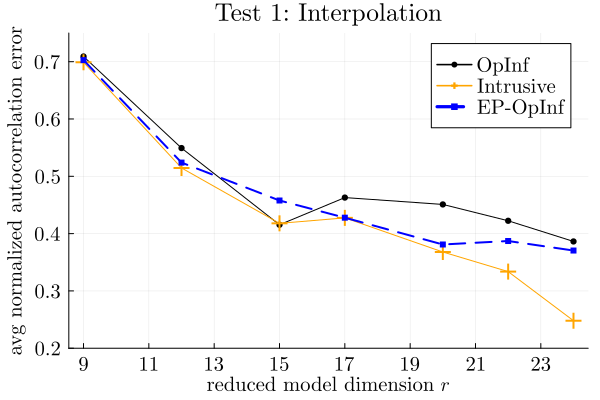

In [9]:
p = plot(DATA["ro"], TEST_RES["test1_AC_ERR"][:LS], c=:black, marker=(:circle, 3.5, :black), label="OpInf")
plot!(DATA["ro"], TEST_RES["test1_AC_ERR"][:int], c=:orange, marker=(:cross, 8, :orange), markerstrokewidth=2.5, label="Intrusive")
plot!(DATA["ro"], TEST_RES["test1_AC_ERR"][:ephec], c=:blue, markerstrokecolor=:blue, marker=(:rect, 3), ls=:dash, lw=2, label="EP-OpInf")

plot!(majorgrid=true, legend=:topright)
xlabel!("reduced model dimension " * L" r")
ylabel!("avg normalized autocorrelation error")
# yticks!([1e-0, 1e-1, 1e-2, 1e-3])
title!("Test 1: Interpolation", titlefontsize=16)
xticks!(DATA["ro"][1]:2:DATA["ro"][end])
ylims!((0.2, 0.75))
plot!(left_margin=2mm)
plot!(fontfamily="Computer Modern", guidefontsize=13, tickfontsize=13,  legendfontsize=13)
# savefig(p, "figures/kse_test1_ac_err.pdf")

In [5]:
i = 25
r = DATA["ro"][end]

# Random input within the training region
println("a = $(ic_a_rand_in[i]), b = $(ic_b_rand_in[i])")
ic = u0(ic_a_rand_in[i], ic_b_rand_in[i])

Vr = DATA["Vr"][1][:, 1:r]
tspan = collect(KSE.T[1]:KSE.Δt:KSE.T[2])

X_fom1 = KSE.integrate_FD(DATA["op_fom_tr"][1].A, DATA["op_fom_tr"][1].F, tspan, ic)
X_int1 = KSE.integrate_FD(OPS["op_int"][1].A[1:r, 1:r], LnL.extractF(OPS["op_int"][1].F, r), tspan, Vr' * ic)
X_LS1 = KSE.integrate_FD(OPS["op_LS"][1].A[1:r, 1:r], LnL.extractF(OPS["op_LS"][1].F, r), tspan, Vr' * ic)
X_ephec1 = KSE.integrate_FD(OPS["op_ephec"][1].A[1:r, 1:r], LnL.extractF(OPS["op_ephec"][1].F, r), tspan, Vr' * ic)
# X_epsic = KSE.integrate_FD(OPS["op_epsic"][1].A[1:r, 1:r], LnL.extractF(OPS["op_epsic"][1].F, r), KSE.t, Vr' * ic)
# X_epp = KSE.integrate_FD(OPS["op_epp"][1].A[1:r, 1:r], LnL.extractF(OPS["op_epp"][1].F, r), KSE.t, Vr' * ic)
;

a = 1.1140757304907225, b = 0.5134537566333595


In [26]:
# lout = @layout [a{0.3h}; [grid(2,2)]]
lout = @layout [grid(4,2)]
p_fom = plot(
    contourf(tspan[1:DS:end], KSE.x, X_fom1[:, 1:DS:end], lw=0, color=:inferno), 
    colorbar_ticks=(-3:3), yticks=(0:5:20), ylims=(0,22), 
    #right_margin=-3mm, left_margin=3mm, 
    left_margin=15mm, top_margin=5mm,
    ylabel=L"\textbf{Full}" * "\n" * L"\omega",
    xformatter=_->"",
)
pblank = plot(
    axis=false,legend=false,grid=false,foreground_color_subplot=:transparent, 
    #left_margin=-3mm, right_margin=-3mm, top_margin=5mm,
)
p_int = plot(
    contourf(tspan[1:DS:end], KSE.x, Vr * X_int1[:, 1:DS:end], lw=0, color=:inferno), 
    colorbar_ticks=(-3:3), yticks=(0:5:20), ylims=(0,22), 
    #right_margin=-3mm, left_margin=3mm, top_margin=-2mm,
    left_margin=15mm,
    ylabel=L"\textbf{Intrusive}" * "\n" * L"\omega", 
    xformatter=_->"",
)
p_int_err = plot(
    contourf(tspan[1:DS:end], KSE.x, abs.(X_fom1[:, 1:DS:end] .- Vr * X_int1[:, 1:DS:end]), lw=0, color=:roma), 
    yticks=(0:5:20), ylims=(0,22), colorbar_ticks=(0:0.5:5), clim=(0,5), 
    #left_margin=-3mm, right_margin=-3mm,
    xformatter=_->"", yformatter=_->"",
)
p_LS = plot(
    contourf(tspan[1:DS:end], KSE.x, Vr * X_LS1[:, 1:DS:end], lw=0, color=:inferno), 
    colorbar_ticks=(-3:3), yticks=(0:5:20), ylims=(0,22), 
    #right_margin=-3mm, left_margin=3mm, top_margin=-2mm,
    left_margin=15mm,
    ylabel=L"\textbf{OpInf}" * "\n" * L"\omega",
    xformatter=_->"",
)
p_LS_err = plot(
    contourf(tspan[1:DS:end], KSE.x, abs.(X_fom1[:, 1:DS:end] .- Vr * X_LS1[:, 1:DS:end]), lw=0, color=:roma), 
    yticks=(0:5:20), ylims=(0,22),  colorbar_ticks=(0:0.5:5), clim=(0,5), 
    #left_margin=-3mm, right_margin=-3mm, top_margin=-2mm
    xformatter=_->"", yformatter=_->"",
)
p_ephec = plot(
    contourf(tspan[1:DS:end], KSE.x, Vr * X_ephec1[:, 1:DS:end], lw=0, color=:inferno), 
    colorbar_ticks=(-3:3), yticks=(0:5:20), ylims=(0,22), 
    #right_margin=-3mm, left_margin=3mm,  bottom_margin=7mm, top_margin=-2mm,
    bottom_margin=15mm, left_margin=15mm,
    ylabel=L"\textbf{EP}\rm{-}\textbf{OpInf}" * "\n" * L"\omega", xlabel=L"t" * "\n" * L"\textbf{Predicted}~" * L"x(\omega,t)",
)
p_ephec_err = plot(
    contourf(tspan[1:DS:end], KSE.x, abs.(X_fom1[:, 1:DS:end] .- Vr * X_ephec1[:, 1:DS:end]), lw=0, color=:roma), 
    yticks=(0:5:20), ylims=(0,22), colorbar_ticks=(0:0.5:5), clim=(0,5), 
    #left_margin=-3mm, right_margin=-3mm, bottom_margin=7mm,  top_margin=-2mm,
    bottom_margin=15mm,
    xlabel=L"t" * "\n" * L"\textbf{Error}", 
    yformatter=_->"",
)
# p_epsic = plot(contourf(KSE.t[1:DS:end], KSE.x, Vr * X_epsic[:, 1:DS:end], lw=0), colorbar_ticks=(-3:3), clim=(-3,3), yticks=(0:5:20), ylims=(0,20))
# p_epsic_err = plot(contourf(KSE.t[1:DS:end], KSE.x, abs.(DATA["Xtr_all"][i][:, 1:DS:end] .- Vr * X_epsic[:, 1:DS:end]), lw=0, color=:roma), yticks=(0:5:20), ylims=(0,20), colorbar_ticks=(0:0.5:5), clim=(0,5))
# p_epp = plot(contourf(KSE.t[1:DS:end], KSE.x, Vr * X_epp[:, 1:DS:end], lw=0), colorbar_ticks=(-3:3), clim=(-3,3), yticks=(0:5:20), ylims=(0,20))
# p_epp_err = plot(contourf(KSE.t[1:DS:end], KSE.x, abs.(DATA["Xtr_all"][i][:, 1:DS:end] .- Vr * X_epp[:, 1:DS:end]), lw=0, color=:roma), yticks=(0:5:20), ylims=(0,20), colorbar_ticks=(0:0.5:5), clim=(0,5))

p1 = plot(
    p_fom, pblank, 
    p_int, p_int_err,
    p_LS, p_LS_err,
    p_ephec, p_ephec_err,
    # p_epsic, p_epsic_err,
    # p_epp, p_epp_err, 
    fontfamily="Computer Modern", layout=lout, 
    size=(2000, 1080),
    guidefontsize=25, tickfontsize=17, plot_titlefontsize=30, plot_titlefontcolor=:white,
    plot_title="Predicted Flow Fields and Errors of Test 1: Interpolation"
)
plot!(p1, background_color=:transparent, background_color_inside=:transparent, dpi=600)
savefig(p1, "figures/kse_test1_ff.png")

"c:\\Users\\tkoike3\\Code\\LiftAndLearn.jl\\examples\\figures\\kse_test1_ff.png"

## Test 2

In [8]:
TEST_RES["test2_AC"] = Dict(
    :int   => Array{Array{Float64}}(undef, length(DATA["ro"]), KSE.Pdim),
    :LS    => Array{Array{Float64}}(undef, length(DATA["ro"]), KSE.Pdim),
    :ephec => Array{Array{Float64}}(undef, length(DATA["ro"]), KSE.Pdim),
    :fom   => Array{Array{Float64}}(undef, KSE.Pdim)
)
TEST_RES["test2_AC_ERR"] = Dict(
    :int   => Array{Float64}(undef, length(DATA["ro"]), KSE.Pdim),
    :LS    => Array{Float64}(undef, length(DATA["ro"]), KSE.Pdim),
    :ephec => Array{Float64}(undef, length(DATA["ro"]), KSE.Pdim),
);

In [9]:
# Generate random initial condition parameters
ic_a_out = [0.0, 2.0]
ic_b_out = [0.0, 0.8]
ϵ=1e-2
half_num_test_ic = Int(num_test_ic/2)
ic_a_rand_out = ((minimum(ic_a) - ϵ) - ic_a_out[1]) .* rand(half_num_test_ic) .+ ic_a_out[1]
append!(ic_a_rand_out, (ic_a_out[2] - (maximum(ic_a) + ϵ)) .* rand(half_num_test_ic) .+ (maximum(ic_a) + ϵ))
ic_b_rand_out = ((minimum(ic_b) - ϵ) - ic_b_out[1]) .* rand(half_num_test_ic) .+ ic_b_out[1]
append!(ic_b_rand_out, (ic_b_out[2] - (maximum(ic_b) + ϵ)) .* rand(half_num_test_ic) .+ (maximum(ic_b) + ϵ))

i = 1
μ = KSE.μs[i]

# Generate the FOM system matrices (ONLY DEPENDS ON μ)
A = DATA["op_fom_tr"][i].A
F = DATA["op_fom_tr"][i].F

# lag for autocorrelation
lags = 0:DS:(KSE.Tdim ÷ 2)
idx = length(lags)

# Store some arrays
fom_ac2 = zeros(length(lags))
int_ac2 = zeros(length(lags), length(DATA["ro"]))
LS_ac2 = zeros(length(lags), length(DATA["ro"]))
ephec_ac2 = zeros(length(lags), length(DATA["ro"]))

int_ac_err2 = zeros(length(DATA["ro"]))
LS_ac_err2 = zeros(length(DATA["ro"]))
ephec_ac_err2 = zeros(length(DATA["ro"]))

# Generate the data for all combinations of the initial condition parameters
prog = Progress(num_test_ic)
Threads.@threads for j in 1:num_test_ic  
    # generate test 1 data
    a = ic_a_rand_out[j]
    b = ic_b_rand_out[j]
    IC = u0(a,b)
    Xtest_out = KSE.integrate_FD(A, F, KSE.t, IC)

    # compute autocorrelation of FOM
    fom_ac_j = tmean_autocorr(Xtest_out, lags)
    fom_ac2 .+= fom_ac_j

    # compute autocorrelation of ROMs
    int_ac_tmp = analyze_autocorr(OPS["op_int"], KSE, DATA["Vr"], IC, DATA["ro"], KSE.integrate_FD, lags)
    LS_ac_tmp = analyze_autocorr(OPS["op_LS"], KSE, DATA["Vr"], IC, DATA["ro"], KSE.integrate_FD, lags)
    ephec_ac_tmp = analyze_autocorr(OPS["op_ephec"], KSE, DATA["Vr"], IC, DATA["ro"], KSE.integrate_FD, lags)
    for r in eachindex(DATA["ro"])
        int_ac_err2[r] += norm(int_ac_tmp[r,1] - fom_ac_j, 2) / norm(fom_ac_j, 2)
        int_ac2[:,r] .+= int_ac_tmp[r,1]

        LS_ac_err2[r] += norm(LS_ac_tmp[r,1] - fom_ac_j, 2) / norm(fom_ac_j, 2)
        LS_ac2[:,r] .+= LS_ac_tmp[r,1]

        ephec_ac_err2[r] += norm(ephec_ac_tmp[r,1] - fom_ac_j, 2) / norm(fom_ac_j, 2)
        ephec_ac2[:,r] .+= ephec_ac_tmp[r,1]
    end

    next!(prog)
end

TEST_RES["test2_AC"][:fom][1] = fom_ac2 ./ num_test_ic
for r in eachindex(DATA["ro"])
    TEST_RES["test2_AC"][:int][r,1] = int_ac2[:,r] / num_test_ic
    TEST_RES["test2_AC"][:LS][r,1] = LS_ac2[:,r] / num_test_ic
    TEST_RES["test2_AC"][:ephec][r,1] = ephec_ac2[:,r] / num_test_ic

    TEST_RES["test2_AC_ERR"][:int][r,1] = int_ac_err2[r] / num_test_ic
    TEST_RES["test2_AC_ERR"][:LS][r,1] = LS_ac_err2[r] / num_test_ic
    TEST_RES["test2_AC_ERR"][:ephec][r,1] = ephec_ac_err2[r] / num_test_ic
end

Progress:   4%|██                                       |  ETA: 1 days, 16:19:21

Progress:  26%|███████████                              |  ETA: 9:24:44

Progress:  50%|█████████████████████                    |  ETA: 5:10:16

Progress:  74%|███████████████████████████████          |  ETA: 2:23:16

Progress:  98%|█████████████████████████████████████████|  ETA: 0:09:26

Progress: 100%|█████████████████████████████████████████| Time: 7:45:14


In [73]:
save(testresultfile, "TEST_RES", TEST_RES)

In [ ]:
lags_t = collect(lags) .* KSE.Δt
idx = length(lags_t)
lout = @layout [grid(2,2)]
p = plot(layout=lout, size=(1000, 500), plot_title="Test 2: extrapolation")
for (plot_id, ri) in enumerate([1, 2, 5, 7])
    plot!(p[plot_id], lags_t[1:idx], TEST_RES["test2_AC"][:LS][ri][1:idx], c=:black, label="opinf")
    plot!(p[plot_id], lags_t[1:idx], TEST_RES["test2_AC"][:int][ri][1:idx], c=:orange, label="intrusive")
    plot!(p[plot_id], lags_t[1:idx], TEST_RES["test2_AC"][:ephec][ri][1:idx], c=:blue, ls=:dash, lw=2, label="ep-opinf")
    # plot!(p[plot_id], lags_t, TEST_RES["test2_AC"][:epsic][ri], c=:purple, ls=:dot, label="epsic-opinf")
    # plot!(p[plot_id], lags_t, TEST_RES["test2_AC"][:epp][ri], c=:red, lw=1, ls=:dash, label="epp-opinf")
    plot!(p[plot_id], lags_t[1:idx], TEST_RES["test2_AC"][:fom][1][1:idx], c=:green, lw=1, ls=:dash, label="fom")
    plot!(p[plot_id], fontfamily="Computer Modern", guidefontsize=12, tickfontsize=13)
    plot!(p[plot_id], title="r = $(DATA["ro"][ri])", titlefontsize=14, titlefontfamily="Computer Modern")
    # xlabel!(p[plot_id], "lag")
    # ylabel!(p[plot_id], "normalized autocorrelation")
    yticks!(p[plot_id], [-0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

    if plot_id == 4
        plot!(p[plot_id], legend=:topright, legend_column=2, legendfontsize=12)
    else
        plot!(p[plot_id], legend=false)
    end
end
plot!(p[1], left_margin=9mm)
plot!(p[3], bottom_margin=10mm, left_margin=9mm)
plot!(p[4], bottom_margin=10mm)
annotate!(p[4], -20, -0.48, "time lag", annotationfontsize=16)
annotate!(p[1], -30, -0.4, Plots.text("average normalized autocorrelation", 16, rotation=90, "Computer Modern"))
savefig(p, "test2_ac4.pdf")

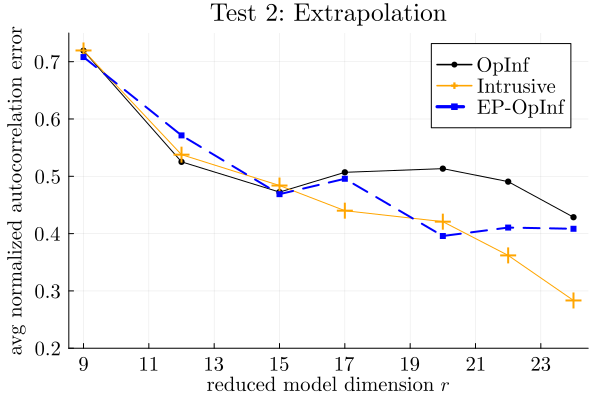

In [12]:
p = plot(DATA["ro"], TEST_RES["test2_AC_ERR"][:LS], c=:black, marker=(:circle, 3.5, :black), label="OpInf")
plot!(DATA["ro"], TEST_RES["test2_AC_ERR"][:int], c=:orange, marker=(:cross, 8, :orange), markerstrokewidth=2.5, label="Intrusive")
plot!(DATA["ro"], TEST_RES["test2_AC_ERR"][:ephec], c=:blue, markerstrokecolor=:blue, marker=(:rect, 3), ls=:dash, lw=2, label="EP-OpInf")

plot!(majorgrid=true, legend=:topright)
xlabel!("reduced model dimension " * L" r")
ylabel!("avg normalized autocorrelation error")
# yticks!([1e-0, 1e-1, 1e-2, 1e-3])
title!("Test 2: Extrapolation", titlefontsize=16)
ylims!((0.2, 0.75))
xticks!(DATA["ro"][1]:2:DATA["ro"][end])
plot!(left_margin=2mm)
plot!(fontfamily="Computer Modern", guidefontsize=13, tickfontsize=13,  legendfontsize=13)
savefig(p, "figures/kse_test2_ac_err.pdf")

In [6]:
i = 25
r = DATA["ro"][end]

# Random input outside the training region
println("a = $(ic_a_rand_out[i]), b = $(ic_b_rand_out[i])")
ic = u0(ic_a_rand_out[i], ic_b_rand_out[i])

Vr = DATA["Vr"][1][:, 1:r]
tspan = collect(KSE.T[1]:KSE.Δt:KSE.T[2])

X_fom2 = KSE.integrate_FD(DATA["op_fom_tr"][1].A, DATA["op_fom_tr"][1].F, tspan, ic)
X_int2 = KSE.integrate_FD(OPS["op_int"][1].A[1:r, 1:r], LnL.extractF(OPS["op_int"][1].F, r), tspan, Vr' * ic)
X_LS2 = KSE.integrate_FD(OPS["op_LS"][1].A[1:r, 1:r], LnL.extractF(OPS["op_LS"][1].F, r), tspan, Vr' * ic)
X_ephec2 = KSE.integrate_FD(OPS["op_ephec"][1].A[1:r, 1:r], LnL.extractF(OPS["op_ephec"][1].F, r), tspan, Vr' * ic)
# X_epsic = KSE.integrate_FD(OPS["op_epsic"][1].A[1:r, 1:r], LnL.extractF(OPS["op_epsic"][1].F, r), KSE.t, Vr' * ic)
# X_epp = KSE.integrate_FD(OPS["op_epp"][1].A[1:r, 1:r], LnL.extractF(OPS["op_epp"][1].F, r), KSE.t, Vr' * ic)
;

a = 0.5054669434644398, b = 0.030834677937429816


In [24]:
# lout = @layout [a{0.3h}; [grid(2,2)]]
lout = @layout [grid(4,2)]
p_fom = plot(
    contourf(tspan[1:DS:end], KSE.x, X_fom2[:, 1:DS:end], lw=0, color=:inferno), 
    colorbar_ticks=(-3:3), clim=(-3.1,3.01), yticks=(0:5:20), ylims=(0,22), 
    #right_margin=-3mm, left_margin=3mm, 
    left_margin=15mm, top_margin=5mm,
    ylabel=L"\textbf{Full}" * "\n" * L"\omega",
    xformatter=_->"",
)
pblank = plot(
    axis=false,legend=false,grid=false,foreground_color_subplot=:transparent, 
    # left_margin=-3mm, right_margin=-3mm, top_margin=5mm,
)
p_int = plot(
    contourf(tspan[1:DS:end], KSE.x, Vr * X_int2[:, 1:DS:end], lw=0, color=:inferno), 
    colorbar_ticks=(-3:3), clim=(-3.1,3.01), yticks=(0:5:20), ylims=(0,22), 
    #right_margin=-3mm, left_margin=3mm, top_margin=-2mm,
    left_margin=15mm,
    ylabel=L"\textbf{Intrusive}" * "\n" * L"\omega", 
    xformatter=_->"",
)
p_int_err = plot(
    contourf(tspan[1:DS:end], KSE.x, abs.(X_fom2[:, 1:DS:end] .- Vr * X_int2[:, 1:DS:end]), lw=0, color=:roma), 
    yticks=(0:5:20), ylims=(0,22), colorbar_ticks=(0:0.5:5), clim=(0,5), 
    #left_margin=-3mm, right_margin=-3mm, top_margin=-2mm
    xformatter=_->"", yformatter=_->"",
)
p_LS = plot(
    contourf(tspan[1:DS:end], KSE.x, Vr * X_LS2[:, 1:DS:end], lw=0, color=:inferno), 
    colorbar_ticks=(-3:3), yticks=(0:5:20), ylims=(0,22), 
    #right_margin=-3mm, left_margin=3mm, top_margin=-2mm,
    left_margin=15mm,
    ylabel=L"\textbf{OpInf}" * "\n" * L"\omega",
    xformatter=_->"",
)
p_LS_err = plot(
    contourf(tspan[1:DS:end], KSE.x, abs.(X_fom2[:, 1:DS:end] .- Vr * X_LS2[:, 1:DS:end]), lw=0, color=:roma), 
    yticks=(0:5:20), ylims=(0,22),  colorbar_ticks=(0:0.5:5), clim=(0,5), 
    #left_margin=-3mm, right_margin=-3mm, top_margin=-2mm
    xformatter=_->"", yformatter=_->"",
)
p_ephec = plot(
    contourf(tspan[1:DS:end], KSE.x, Vr * X_ephec2[:, 1:DS:end], lw=0, color=:inferno), 
    colorbar_ticks=(-3:3), yticks=(0:5:20), ylims=(0,22), 
    #right_margin=-3mm, left_margin=3mm,  bottom_margin=7mm, top_margin=-2mm,
    bottom_margin=15mm, left_margin=15mm,
    ylabel=L"\textbf{EP}" * L"\rm{-}" * L"\textbf{OpInf}" * "\n" * L"\omega", xlabel=L"t" * "\n" * L"\textbf{Predicted}~" * L"x(\omega,t)",
)
p_ephec_err = plot(
    contourf(tspan[1:DS:end], KSE.x, abs.(X_fom2[:, 1:DS:end] .- Vr * X_ephec2[:, 1:DS:end]), lw=0, color=:roma), 
    yticks=(0:5:20), ylims=(0,22), colorbar_ticks=(0:0.5:5), clim=(0,5), 
    #left_margin=-3mm, right_margin=-3mm, bottom_margin=7mm,  top_margin=-2mm,
    bottom_margin=15mm,
    xlabel=L"t" * "\n" * L"\textbf{Error}", 
    yformatter=_->"",
)
# p_epsic = plot(contourf(KSE.t[1:DS:end], KSE.x, Vr * X_epsic[:, 1:DS:end], lw=0), colorbar_ticks=(-3:3), clim=(-3,3), yticks=(0:5:20), ylims=(0,20))
# p_epsic_err = plot(contourf(KSE.t[1:DS:end], KSE.x, abs.(DATA["Xtr_all"][i][:, 1:DS:end] .- Vr * X_epsic[:, 1:DS:end]), lw=0, color=:roma), yticks=(0:5:20), ylims=(0,20), colorbar_ticks=(0:0.5:5), clim=(0,5))
# p_epp = plot(contourf(KSE.t[1:DS:end], KSE.x, Vr * X_epp[:, 1:DS:end], lw=0), colorbar_ticks=(-3:3), clim=(-3,3), yticks=(0:5:20), ylims=(0,20))
# p_epp_err = plot(contourf(KSE.t[1:DS:end], KSE.x, abs.(DATA["Xtr_all"][i][:, 1:DS:end] .- Vr * X_epp[:, 1:DS:end]), lw=0, color=:roma), yticks=(0:5:20), ylims=(0,20), colorbar_ticks=(0:0.5:5), clim=(0,5))

p2 = plot(
    p_fom, pblank, 
    p_int, p_int_err,
    p_LS, p_LS_err,
    p_ephec, p_ephec_err,
    # p_epsic, p_epsic_err,
    # p_epp, p_epp_err, 
    fontfamily="Computer Modern", layout=lout, 
    size=(2000, 1080),
    guidefontsize=25, tickfontsize=17, plot_titlefontsize=30, plot_titlefontcolor=:white,
    plot_title="Predicted Flow Fields and Errors of Test 2: Extrapolation"
)
plot!(p2, background_color=:transparent, background_color_inside=:transparent, dpi=600)
savefig(p2, "figures/kse_test2_ff.png")

"c:\\Users\\tkoike3\\Code\\LiftAndLearn.jl\\examples\\figures\\kse_test2_ff.png"

In [74]:
save("data/kse_test_ics_L22.jld2", 
    Dict(
        "ic_a_rand_in" => ic_a_rand_in,
        "ic_b_rand_in" => ic_b_rand_in,
        "ic_a_rand_out" => ic_a_rand_out,
        "ic_b_rand_out" => ic_b_rand_out
    )
)

#### Future work (Lypuanov Exponents)

In [ ]:
# TEST_RES["test1_LE"] = Dict(
#     :int   => Array{Array{Float64}}(undef, length(DATA["ro"]), KSE.Pdim),
#     :LS    => Array{Array{Float64}}(undef, length(DATA["ro"]), KSE.Pdim),
#     :ephec => Array{Array{Float64}}(undef, length(DATA["ro"]), KSE.Pdim),
#     :epsic => Array{Array{Float64}}(undef, length(DATA["ro"]), KSE.Pdim),
#     :epp   => Array{Array{Float64}}(undef, length(DATA["ro"]), KSE.Pdim),
#     :fom   => Array{Array{Float64}}(undef, KSE.Pdim)
# )
# TEST_RES["test2_LE"] = Dict(
#     :int   => Array{Array{Float64}}(undef, length(DATA["ro"]), KSE.Pdim),
#     :LS    => Array{Array{Float64}}(undef, length(DATA["ro"]), KSE.Pdim),
#     :ephec => Array{Array{Float64}}(undef, length(DATA["ro"]), KSE.Pdim),
#     :epsic => Array{Array{Float64}}(undef, length(DATA["ro"]), KSE.Pdim),
#     :epp   => Array{Array{Float64}}(undef, length(DATA["ro"]), KSE.Pdim),
#     :fom   => Array{Array{Float64}}(undef, KSE.Pdim)
# )
# TEST_RES["test1_DKY"] = Dict(
#     :int   => Array{Float64}(undef, length(DATA["ro"]), KSE.Pdim),
#     :LS    => Array{Float64}(undef, length(DATA["ro"]), KSE.Pdim),
#     :ephec => Array{Float64}(undef, length(DATA["ro"]), KSE.Pdim),
#     :epsic => Array{Float64}(undef, length(DATA["ro"]), KSE.Pdim),
#     :epp   => Array{Float64}(undef, length(DATA["ro"]), KSE.Pdim),
#     :fom   => Array{Float64}(undef, KSE.Pdim)
# )
# TEST_RES["test2_DKY"] = Dict(
#     :int   => Array{Float64}(undef, length(DATA["ro"]), KSE.Pdim),
#     :LS    => Array{Float64}(undef, length(DATA["ro"]), KSE.Pdim),
#     :ephec => Array{Float64}(undef, length(DATA["ro"]), KSE.Pdim),
#     :epsic => Array{Float64}(undef, length(DATA["ro"]), KSE.Pdim),
#     :epp   => Array{Float64}(undef, length(DATA["ro"]), KSE.Pdim),
#     :fom   => Array{Float64}(undef, KSE.Pdim)
# )
# TEST_RES["test1_LE_all"] = Dict(
#     :int   => Array{Array{Float64}}(undef, length(DATA["ro"]), KSE.Pdim),
#     :LS    => Array{Array{Float64}}(undef, length(DATA["ro"]), KSE.Pdim),
#     :ephec => Array{Array{Float64}}(undef, length(DATA["ro"]), KSE.Pdim),
#     :epsic => Array{Array{Float64}}(undef, length(DATA["ro"]), KSE.Pdim),
#     :epp   => Array{Array{Float64}}(undef, length(DATA["ro"]), KSE.Pdim),
#     :fom   => Array{Array{Float64}}(undef, KSE.Pdim)
# )
# TEST_RES["test2_LE_all"] = Dict(
#     :int   => Array{Array{Float64}}(undef, length(DATA["ro"]), KSE.Pdim),
#     :LS    => Array{Array{Float64}}(undef, length(DATA["ro"]), KSE.Pdim),
#     :ephec => Array{Array{Float64}}(undef, length(DATA["ro"]), KSE.Pdim),
#     :epsic => Array{Array{Float64}}(undef, length(DATA["ro"]), KSE.Pdim),
#     :epp   => Array{Array{Float64}}(undef, length(DATA["ro"]), KSE.Pdim),
#     :fom   => Array{Array{Float64}}(undef, KSE.Pdim)
# )
;